<a href="https://colab.research.google.com/github/Nourallaah/FitzHugh-Nagumo-Solutions-Simulation/blob/main/numerical_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FitzHugh–Nagumo Numerical Simulation

This code presents the full numerical implementation and simulation of the FitzHugh–Nagumo (FHN) partial differential equation, a classical reaction–diffusion model for excitable media, commonly used to describe neuron membrane dynamics and action potentials.

## Objectives
We aim to:
- Solve the FHN PDE in 1D using two numerical schemes:
  - Euler Finite Difference Method (FDM)
  - Finite Volume Method (FVM)
- Apply various initial and boundary conditions
- Compare results with the analytical benchmark (when available)
- Analyze accuracy, convergence, and relative errors
- Visualize the solution evolution over time
- Provide detailed result tables and error plots

## Structure
This code contains:
1. Model setup and parameters  
2. Implementation of both Euler-FDM and FVM schemes  
3. Boundary and initial condition application  
4. Full simulation with result plots and tables  
5. Comparison with analytical solution  
6. Error analysis and performance discussion

In [91]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd

The first code cell imports the core Python libraries that will be used throughout this notebook:

| Library | Alias | Purpose |
|---------|-------|---------|
| *NumPy* | np | Fast array operations, vectorized math, and numerical utilities |
| *Matplotlib* | plt | Plotting 1-D and 2-D figures (solution curves, error distributions, etc.) |
| *time* | — | Lightweight timing to benchmark execution (Euler vs FVM run-times) |
| *Pandas* | pd | Tabular data structures for neatly printing solution tables and statistics |

These imports are kept minimal—only the essentials required for numerical computation, visualization, and formatted result tables.

In [92]:
# Global Parameters
D, a = 1.0, 0.3
xmin, xmax = -60, 20
N_x = 401
Tfinal = 60.0
dt = 0.002
x = np.linspace(xmin, xmax, N_x)
dx = x[1] - x[0]
Nt = int(Tfinal / dt)
snap_times = np.arange(0, 61, 10)
save_steps = (snap_times / dt).astype(int)

In this section, we define the global parameters used to numerically solve the FitzHugh–Nagumo equation:

- D = 1.0: Diffusion coefficient in the PDE.
- a = 0.3: Threshold parameter that controls the excitation.
- xmin = -60, xmax = 20: The spatial domain ranges from -60 to 20.
- N_x = 401: Number of grid points in the spatial domain.
- Tfinal = 60.0: The final simulation time.
- dt = 0.002: Time step size for the numerical integration.
- x = np.linspace(xmin, xmax, N_x): Uniformly spaced spatial grid.
- dx = x[1] - x[0]: Spatial resolution (grid spacing).
- Nt = int(Tfinal / dt): Total number of time steps.
- snap_times = np.arange(0, 61, 10): Time instances at which we save snapshots of the solution.
- save_steps = (snap_times / dt).astype(int): Convert snapshot times into corresponding time step indices.

These values control the accuracy and resolution of the numerical simulation using both Euler and FVM (Finite Volume Method).

In [93]:
def safe_exp(z): return np.exp(np.clip(z, -700, 700))

To avoid numerical overflow during exponential calculations, we define a safe_exp function:

In [94]:
# Analytical Solution and Derivative
def analytical_solution(x, t, D=1.0, a=0.3):
    x = x.reshape(-1, 1) if isinstance(t, np.ndarray) else x
    t = t.reshape(1, -1) if isinstance(t, np.ndarray) else t
    arg = x / np.sqrt(2 * D) + (a - 0.5) * t
    return 1 / (1 + safe_exp(arg))

def ux_exact(x, t):
    x = x.reshape(-1, 1) if isinstance(t, np.ndarray) else x
    t = t.reshape(1, -1) if isinstance(t, np.ndarray) else t
    arg = x / np.sqrt(2 * D) + (a - 0.5) * t
    e = safe_exp(arg)
    return -e / (np.sqrt(2 * D) * (1 + e)**2)

###  Analytical Solution and Its Spatial Derivative

The following expressions represent the exact analytical solution and its spatial derivative for the FitzHugh–Nagumo partial differential equation.

#### Exact Analytical Solution

The closed-form solution for the membrane potential is:

$$
u(x,t) = \frac{1}{1 + \exp\left( \frac{x}{\sqrt{2D}} + (a - 0.5)t \right)}
$$

This function describes how the potential evolves over time and space. It is used as a reference to initialize the system and to evaluate the accuracy of the numerical solvers.

#### Exact Spatial Derivative

The spatial derivative of the solution is given by:

$$
\frac{\partial u}{\partial x} = -\frac{e}{\sqrt{2D}(1 + e)^2}, \quad
\text{where} \quad e = \exp\left( \frac{x}{\sqrt{2D}} + (a - 0.5)t \right)
$$

This derivative is useful for:

- Applying Neumann-type boundary conditions,
- Comparing numerical approximations to exact gradients,
- Calculating error metrics.
 comparing Euler FDM & FVM outputs to ground truth. |

In [95]:
# Initial Conditions
def ic_smooth(): return analytical_solution(x, 0).flatten()
def ic_step():
    u0 = np.ones_like(x)
    u0[x > 0] = 0
    u0[np.abs(x) < 1e-12] = 0.5
    return u0

### Initial Conditions

In this section, we define the two initial conditions (ICs) used for solving the FitzHugh–Nagumo PDE:

- *ic_smooth()*  
  This function returns a smooth initial profile that matches the analytical solution at time t = 0.  
  It is useful when we want to assess the accuracy of the numerical scheme, since the simulation starts from a known exact state.

- *ic_step()*  
  This function generates a unit-step profile:
  - The value is 1 for all x < 0,
  - 0 for all x > 0,
  - And 0.5 at x = 0 to smoothly handle the discontinuity at the center.  

  This discontinuous IC tests the stability and robustness of the numerical solvers when dealing with sharp gradients, which are common in biological excitation models.

Using both smooth and step initial conditions allows us to evaluate the performance of each numerical method under different difficulty levels.

In [96]:
# Boundary Conditions
def apply_bc(u, t, ncase):
    if ncase == 1: u[0], u[-1] = analytical_solution(x[0], t), analytical_solution(x[-1], t)
    elif ncase == 2: u[0], u[-1] = 1.0, 0.0
    elif ncase == 3:
        u[0] = u[1] - dx * ux_exact(x[0], t)
        u[-1] = u[-2] + dx * ux_exact(x[-1], t)
    elif ncase == 4: u[0], u[-1] = u[1], u[-2]
    elif ncase == 5: u[0], u[-1] = u[1], u[-2]
    return u

### Boundary-Condition
according to one of five pre-defined boundary-condition cases:

| Case | Label | Mathematical prescription applied at every time step |
|----------|-----------|-----------------------------------------------------------|
| 1 | Dirichlet – Analytical | $$u_0(t)=u_a(x_0,t), \qquad u_{N_x-1}(t)=u_a(x_{N_x-1},t)$$ |
| 2 | Dirichlet – Constant   | $$u_0(t)=1.0, \qquad u_{N_x-1}(t)=0.0$$ |
| 3 | Neumann – Analytical   | $$u_0(t)=u_1(t)-\Delta x\,u_x^{\mathrm{exact}}(x_0,t)$$ $$u_{N_x-1}(t)=u_{N_x-2}(t)+\Delta x\,u_x^{\mathrm{exact}}\!(x_{N_x-1},t)$$ |
| 4 | Neumann – Homogeneous  | $$u_0(t)=u_1(t), \qquad u_{N_x-1}(t)=u_{N_x-2}(t) \quad(\partial u/\partial x=0)$$ |
| 5 | Free / Copy            | $$u_0(t)=u_1(t), \qquad u_{N_x-1}(t)=u_{N_x-2}(t)$$ |


> • u_a is the analytical solution used as an exact Dirichlet reference.  
> • u_x is the exact spatial derivative for Neumann reference data.  
> • Cases 4 and 5 are numerically identical for a uniform grid; case 5 is simply a “free” (copy) boundary sometimes used as a quick test.

After choosing a case number ncase, the call  

u = apply_bc(u, t_current, ncase)

In [97]:
# Simulation Settings
cases_BC = {1: "Dirichlet-Analytical", 2: "Dirichlet-Constant",
            3: "Neumann-Analytical", 4: "Neumann-Homogeneous", 5: "Free"}
ICs = {"smooth": ic_smooth, "step": ic_step}
# set ncase ( 1, 2, 3, 4, or 5) --------
ncase = 1

### Simulation Settings

This section defines the configuration dictionaries used to map numerical identifiers to readable descriptions for:

#### • Boundary Conditions (cases_BC)
A dictionary mapping integers to string labels for the five implemented boundary condition types:

- 1: Dirichlet-Analytical
- 2: Dirichlet-Constant
- 3: Neumann-Analytical
- 4: Neumann-Homogeneous
- 5: Free

These values are used as input to the apply_bc() function to select the boundary condition for a specific simulation.

#### • Initial Conditions (ICs)
A dictionary mapping string keys to the respective functions defining the initial condition:

- "smooth": uses the analytical solution at t = 0
- "step": defines a unit step function centered at x = 0

These mappings allow us to flexibly run simulations with different physical scenarios by referencing readable keys.

In [98]:
#Euler FDM Solver
def euler_fdm(u0, ncase):
    u = u0.copy()
    sn = []
    for n in range(Nt + 1):
        if n in save_steps:
            sn.append(u.copy())
        rhs = D * (u[2:] - 2 * u[1:-1] + u[:-2]) / dx**2 - u[1:-1] * (1 - u[1:-1]) * (a - u[1:-1])
        u[1:-1] += dt * rhs
        u = apply_bc(u, (n + 1) * dt, ncase)
    return np.array(sn)

## Euler (FDM) :
This function numerically solves a one-dimensional reaction-diffusion equation using the explicit Euler method and finite difference discretization (FDM).

## Function Inputs:
- **u0**: Initial condition array (initial concentration or temperature profile, for example).
- **ncase**: Boundary condition case, passed to the apply_bc() function.

## How it Works:
### Initialization
- **u** is a copy of the initial condition **u0**.
- **sn** is a list to store snapshots (saved solutions) at specific time steps.

### Time-stepping loop (for n in range(Nt + 1)):
For each time step:
- If the current step **n** is in **save_steps**, the current solution **u** is saved in **sn**.

### Finite Difference Discretization
The central difference formula is used to approximate the second spatial derivative (diffusion term):

$$
\frac{\partial^2 u}{\partial x^2} \approx \frac{u[i+1] - 2u[i] + u[i-1]}{dx^2}
$$

The reaction term

$$
u(1-u)(a-u)
$$

is applied to the inner points **u[1:-1]**.

**rhs** stores the total rate of change (diffusion – reaction) at each interior point.

### Euler Time Integration
The explicit Euler method updates the solution:

$$
u^{n+1} = u^n + \Delta t \cdot \text{rhs}
$$

### Apply Boundary Conditions
**apply_bc()** is called to enforce boundary conditions on **u** at each time step.

### Return Solution
After the loop ends, the function returns a NumPy array of the saved solution snapshots.

In [99]:
 # ---------- FVM ----------
def fvm(u0, ncase):
    u = u0.copy()
    sn = []
    for n in range(Nt + 1):
        if n in save_steps:
            sn.append(u.copy())
        flux = np.zeros_like(u)
        flux[1:-1] = D * (u[2:] - u[:-2]) / (2 * dx)
        div_flux = np.zeros_like(u)
        div_flux[1:-1] = (flux[2:] - flux[:-2]) / (2 * dx)
        reaction = u * (1 - u) * (a - u)
        u[1:-1] += dt * (div_flux[1:-1] - reaction[1:-1])
        u = apply_bc(u, (n + 1) * dt, ncase)
    return np.array(sn)

 # Finite Volume Method (FVM) :
  This function numerically solves the partial differential equation using the Finite Volume Method (FVM). It computes the solution u over time using the method of flux balances.

Function: fvm(u0, ncase)
## Inputs:

- u0: initial condition (solution vector at t=0).

- ncase: selected boundary condition case.

## Workflow:
- ### Initialization :
 A copy of the initial solution is made.
An empty list sn is used to store snapshots at selected time steps.

- ### Time Loop :
 At each time step, if it matches a save_steps index, the current solution is saved.

- ### Flux Computation :
The numerical flux across cell faces is computed using central difference:

### Flux Term:
$$
\text{flux}_i = D \cdot \frac{u_{i+1} - u_{i-1}}{2\Delta x}
$$

### Divergence of Flux:
The divergence (net flux out of a control volume) is computed as:
$$
\text{div\_flux}_i = \frac{\text{flux}_{i+1} - \text{f_


- ### Update Rule:

The solution is updated explicitly using the FVM form:

- ### Time-stepping Update Equation:
$$
u_i^{n+1} = u_i^n + \Delta t \cdot \left( \text{div\_flux}_i - \text{reaction}_i \right)
$$

- ### Boundary Conditions:

Boundary conditions are enforced using the apply_bc function.

- ### Output:

Returns an array of saved solution snapshots over time.

In [100]:
# Table Creation Function
def create_table(x, u, ux_num, t, uref=None):
    if uref is not None:
        err = np.abs((u - uref) / uref) * 100 if uref.any() else np.zeros_like(u)
    else:
        err = np.zeros_like(u)
    data = np.column_stack((x, np.full_like(x, t), u, ux_num, err))
    df = pd.DataFrame(data, columns=['x', 't', 'u', 'ux', 'err'])
    return df

# Table Creation Function (create_table)
This function creates a structured table (as a Pandas DataFrame) containing important simulation results at a given time step:

## Inputs:

- x: spatial grid points.

- u: numerical solution at time t.

- ux_num: spatial derivative (or other quantity) at time t.

- t: current time.

- uref (optional): analytical solution at time t (used to compute relative error).

## Output:

A DataFrame with the following columns:

- x: spatial position.

- t: time value (constant for the whole row).

- u: numerical solution.

- ux: computed numerical derivative.

- err: relative error (in %) between numerical and reference solution if available, otherwise 0.

This table is used for organizing results and further analysis, such as plotting or saving to CSV.

In [101]:
# Runner Loop
for ic_name, ic_fun in ICs.items():
    u0 = ic_fun()
    uref = analytical_solution(x, snap_times) if ic_name == "smooth" else None

    bc_name = cases_BC.get(ncase, "Unknown BC")
    if ic_name == "step" and ncase in (1, 3):
        print(f"\n== {ic_name} IC with {bc_name} ==")
        print("No plots available for step IC with this boundary condition.")
        continue

    print(f"\n== Running {ic_name} IC with {bc_name} ==")

    print("→ Euler iterations...")
    start = time.time()
    eu_sn = euler_fdm(u0, ncase)
    print(f"Euler done in {time.time() - start:.2f}s")

    print("→ FVM iterations...")
    start = time.time()
    fv_sn = fvm(u0, ncase)
    print(f"FVM done in {time.time() - start:.2f}s")


== Running smooth IC with Dirichlet-Analytical ==
→ Euler iterations...
Euler done in 1.27s
→ FVM iterations...
FVM done in 1.47s

== step IC with Dirichlet-Analytical ==
No plots available for step IC with this boundary condition.


This loop runs the simulation for each combination of initial conditions (ICs) and boundary condition cases (BCs):

For each IC, the initial profile u0 is generated.

- If the IC is "smooth", we compute the analytical solution to compare with numerical results.

- If the IC is "step" with Dirichlet BC (case 1 or 3), we skip plotting because it’s not valid.

Then we run both solvers:

- euler_fdm() → Finite Difference Method with Euler time integration.

- fvm() → Finite Volume Method.

Execution time for each solver is measured and printed.

The results are saved in eu_sn and fv_sn respectively for further processing (plotting, error analysis, etc.


Euler Table (t = 0):
        x    t             u            ux  err
0   -60.0  0.0  1.000000e+00  0.000000e+00  0.0
1   -59.8  0.0  1.000000e+00  0.000000e+00  0.0
2   -59.6  0.0  1.000000e+00  0.000000e+00  0.0
3   -59.4  0.0  1.000000e+00  0.000000e+00  0.0
4   -59.2  0.0  1.000000e+00  0.000000e+00  0.0
..    ...  ...           ...           ...  ...
396  19.2  0.0  1.270054e-06 -9.010589e-07  0.0
397  19.4  0.0  1.102563e-06 -7.822306e-07  0.0
398  19.6  0.0  9.571613e-07 -6.790729e-07  0.0
399  19.8  0.0  8.309343e-07 -5.895193e-07  0.0
400  20.0  0.0  7.213536e-07 -5.479034e-07  0.0

[401 rows x 5 columns]

Euler Table (t = 10):
        x     t         u        ux  err
0   -60.0  10.0  1.000000  0.000000  0.0
1   -59.8  10.0  1.000000  0.000000  0.0
2   -59.6  10.0  1.000000  0.000000  0.0
3   -59.4  10.0  1.000000  0.000000  0.0
4   -59.2  10.0  1.000000  0.000000  0.0
..    ...   ...       ...       ...  ...
396  19.2  10.0  0.000009 -0.000007  0.0
397  19.4  10.0  0.000008 -

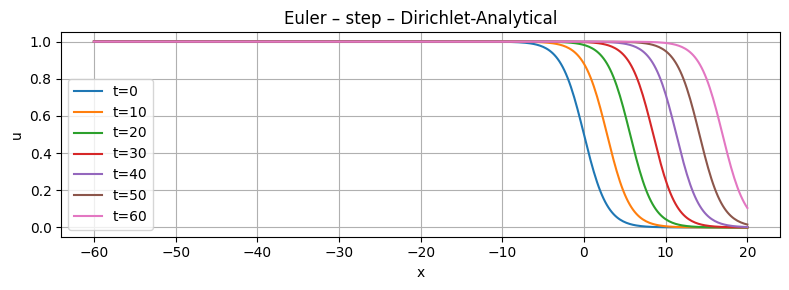

In [102]:
# -- Euler tables and plot
for k, t in enumerate(snap_times):
    eu_u = eu_sn[k]
    ux_eu = np.zeros_like(eu_u)
    ux_eu[1:-1] = (eu_u[2:] - eu_u[:-2]) / (2 * dx)
    ux_eu[0] = (eu_u[1] - eu_u[0]) / dx
    ux_eu[-1] = (eu_u[-1] - eu_u[-2]) / dx
    eu_table = create_table(x, eu_u, ux_eu, t, uref[:, k] if uref is not None else None)
    print(f"\nEuler Table (t = {t}):")
    print(eu_table)

plt.figure(figsize=(8, 3))
for k, t in enumerate(snap_times):
    plt.plot(x, eu_sn[k], label=f"t={t}")
plt.title(f"Euler – {ic_name} – {bc_name}")
plt.xlabel("x"); plt.ylabel("u")
plt.grid(); plt.legend(); plt.tight_layout()
plt.show()

# Euler Solution Tables and Plotting
This block of code generates tables and plots for the solution computed using the Euler Finite Difference Method (FDM).


1. Gradient Calculation:


For each snapshot time t in snap_times:

Compute the numerical spatial derivative
$$
\frac{\partial u}{\partial x}
$$
  using central differences:

For
$$
\frac{u_{i+1} - u_{i-1}}{2\Delta x}, \quad \text{for } 1 \leq i \leq N - 1
$$


For boundaries (forward/backward difference):

- At the left boundary:
$$
\frac{u_1 - u_0}{\Delta x}
$$



- At the right boundary:
$$
\frac{u_N - u_{N-1}}{\Delta x}
$$



2. Table Generation:


Use the create_table() function to generate a table containing:

- Spatial points x

- Time t

- Numerical solution u

- Gradient
$$
\frac{\partial u}{\partial x}
$$



- Relative error (if reference solution is available)

3. Plotting:


- Create a line plot showing the numerical solution
𝑢
(
𝑥
,
𝑡
)
 at each snapshot time.

- The plot helps visualize how the solution evolves over time.

- Useful for comparing behavior under different initial/boundary conditions.


FVM Table (t = 0):
        x    t             u            ux  err
0   -60.0  0.0  1.000000e+00  0.000000e+00  0.0
1   -59.8  0.0  1.000000e+00  0.000000e+00  0.0
2   -59.6  0.0  1.000000e+00  0.000000e+00  0.0
3   -59.4  0.0  1.000000e+00  0.000000e+00  0.0
4   -59.2  0.0  1.000000e+00  0.000000e+00  0.0
..    ...  ...           ...           ...  ...
396  19.2  0.0  1.270054e-06 -9.010589e-07  0.0
397  19.4  0.0  1.102563e-06 -7.822306e-07  0.0
398  19.6  0.0  9.571613e-07 -6.790729e-07  0.0
399  19.8  0.0  8.309343e-07 -5.895193e-07  0.0
400  20.0  0.0  7.213536e-07 -5.479034e-07  0.0

[401 rows x 5 columns]

FVM Table (t = 10):
        x     t         u        ux  err
0   -60.0  10.0  1.000000  0.000000  0.0
1   -59.8  10.0  1.000000  0.000000  0.0
2   -59.6  10.0  1.000000  0.000000  0.0
3   -59.4  10.0  1.000000  0.000000  0.0
4   -59.2  10.0  1.000000  0.000000  0.0
..    ...   ...       ...       ...  ...
396  19.2  10.0  0.000010 -0.000005  0.0
397  19.4  10.0  0.000012 -0.00

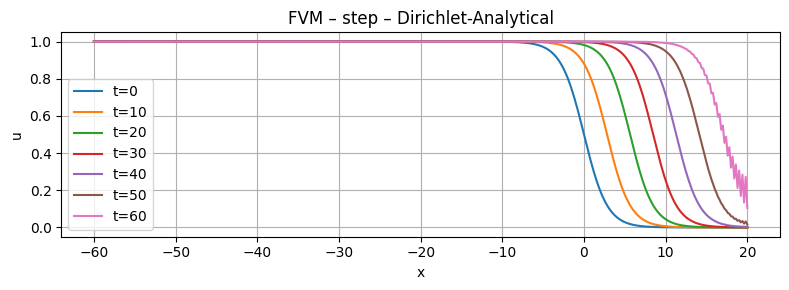

In [103]:

    # -- FVM tables and plot
    for k, t in enumerate(snap_times):
        fv_u = fv_sn[k]
        ux_fv = np.zeros_like(fv_u)
        ux_fv[1:-1] = (fv_u[2:] - fv_u[:-2]) / (2 * dx)
        ux_fv[0] = (fv_u[1] - fv_u[0]) / dx
        ux_fv[-1] = (fv_u[-1] - fv_u[-2]) / dx
        fv_table = create_table(x, fv_u, ux_fv, t, uref[:, k] if uref is not None else None)
        print(f"\nFVM Table (t = {t}):")
        print(fv_table)

    plt.figure(figsize=(8, 3))
    for k, t in enumerate(snap_times):
        plt.plot(x, fv_sn[k], label=f"t={t}")
    plt.title(f"FVM – {ic_name} – {bc_name}")
    plt.xlabel("x"); plt.ylabel("u")
    plt.grid(); plt.legend(); plt.tight_layout()
    plt.show()


# FVM Solution Tables and Plotting
This section handles the post-processing and visualization of the numerical solution computed using the Finite Volume Method (FVM).

1. Gradient Calculation:
For each time step in snap_times, the numerical spatial derivative

$$
\frac{\partial u}{\partial x}
$$

  is computed using:

- Central differences for interior points:

$$
\frac{u_{i+1} - u_{i-1}}{2\Delta x}
$$


Forward/backward differences for boundary points:

$$
\frac{u_1 - u_0}{\Delta x}, \quad \frac{u_N - u_{N-1}}{\Delta x}
$$


2. Table Creation:
A table is created using the create_table() function, containing:

- Spatial coordinate x

- Current time t

- Numerical solution u

- Spatial gradient
$$
\frac{\partial u}{\partial x}
$$


- Relative error with respect to the analytical reference (if available)


3. Plotting:


- A plot of the solution profile
𝑢
(
𝑥
,
𝑡
)
 is generated for each snapshot time.

- This visualization helps evaluate the dynamic behavior of the solution under the given initial and boundary conditions using FVM.

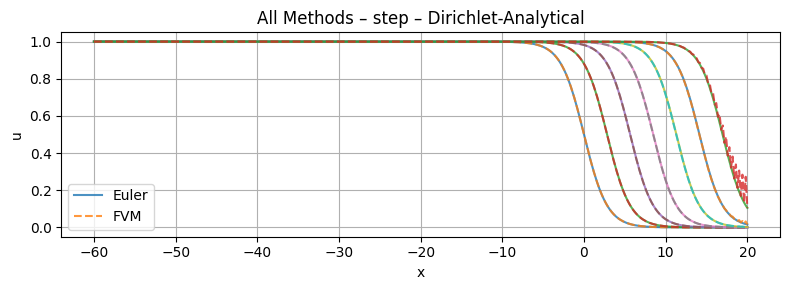

In [104]:
# -- plot combined with analytical
plt.figure(figsize=(8, 3))
for k, t in enumerate(snap_times):
    if uref is not None:
        plt.plot(x, uref[:, k], 'k--', alpha=0.5, label="Analytical" if k == 0 else "")
    plt.plot(x, eu_sn[k], '-', alpha=0.8, label="Euler" if k == 0 else "")
    plt.plot(x, fv_sn[k], '--', alpha=0.8, label="FVM" if k == 0 else "")
plt.title(f"All Methods – {ic_name} – {bc_name}")
plt.xlabel("x"); plt.ylabel("u")
plt.grid(); plt.legend(); plt.tight_layout()
plt.show()

# Combined Plot: Euler, FVM, and Analytical Solution
This section provides a comparative visualization of all numerical and analytical results.

## Purpose:
 ### To compare:

- Euler Finite Difference Method (FDM)

- Finite Volume Method (FVM)

- Analytical solution (if available)

at various snapshot times defined in snap_times.

## Details:
- uref[:, k] is the analytical reference at time t_k, plotted as a dashed black line (k--).

- eu_sn[k] is the Euler solution at t_k, plotted as a solid line.

- fv_sn[k] is the FVM solution at t_k, plotted as a dashed colored line.

The label is added only for the first curve of each method to keep the legend clean.

## Why it matters:
- This plot allows for direct visual comparison:

- Accuracy of each numerical method vs. the true solution.

- Behavior and stability over time.

- Effect of boundary and initial conditions on both methods.

In [105]:
# -- Calculate and print relative errors
if uref is not None:
    rel_error_euler = np.abs((eu_sn - uref.T) / uref.T) * 100
    rel_error_fvm = np.abs((fv_sn - uref.T) / uref.T) * 100
    rel_error_euler[np.isnan(rel_error_euler)] = 0
    rel_error_fvm[np.isnan(rel_error_fvm)] = 0
    avg_rel_euler = np.mean(rel_error_euler, axis=1)  # Average over x for each t
    avg_rel_fvm = np.mean(rel_error_fvm, axis=1)      # Average over x for each t
    print("\nRelative Errors and Averages:")
    for k, t in enumerate(snap_times):
        print(f"t = {t}: Euler Avg Rel Error = {avg_rel_euler[k]:.2f}%, FVM Avg Rel Error = {avg_rel_fvm[k]:.2f}%")


#  Relative Error Calculation and Analysis
This section evaluates the accuracy of the numerical methods (Euler and FVM) by comparing them to the analytical solution.

## Key Steps:
- ## Relative Error Formula:

$$
\text{Relative Error} = \left| \frac{u_{\text{num}} - u_{\text{ref}}}{u_{\text{ref}}} \right| \times 100
$$

where:

- u_num is the numerical solution (Euler or FVM),

- u_ref is the analytical solution.

## Handling NaNs:
In divisions where the reference value is zero, NaNs may appear. These are set to zero for clean averaging.

## Averaging:

The relative error is averaged over all spatial points for each time snapshot.

This gives a single percentage that reflects the overall deviation of the method from the analytical solution at a given time.

## Output:
A printout for each time t, showing:

- Euler Average Relative Error

- FVM Average Relative Error

## Purpose:
To quantitatively compare both methods’ performance over time and observe how errors evolve.

In [106]:
# -- error plot (only for smooth with analytical solution)
if uref is not None:
    plt.figure(figsize=(8, 3))
    rel_err_eu = np.abs((eu_sn - uref.T) / uref.T) * 100
    rel_err_fv = np.abs((fv_sn - uref.T) / uref.T) * 100
    rel_err_eu[np.isnan(rel_err_eu)] = 0
    rel_err_fv[np.isnan(rel_err_fv)] = 0
    plt.plot(x, rel_err_eu[-1], label="Euler Error %")
    plt.plot(x, rel_err_fv[-1], label="FVM Error %")
    plt.title(f"Relative Errors – {ic_name} – {bc_name}")
    plt.xlabel("x"); plt.ylabel("Error (%)")
    plt.grid(); plt.legend(); plt.tight_layout()
    plt.show()

# Relative Error Plot (Final Time Step)


This section visualizes the spatial distribution of relative errors between the analytical and numerical solutions at the final time snapshot.

## Key Points:
- Runs only when the reference (analytical) solution is available (i.e., for the "smooth" initial condition).

- Helps evaluate how accurately the numerical method approximates the true solution.



## Error Calculation:

    
$$
\text{Error}(x) = \left| \frac{u_{\text{num}}(x) - u_{\text{ref}}(x)}{u_{\text{ref}}(x)} \right| \times 100
$$

## Visualization:

Plots the percentage error at each spatial point x for both:

- Euler method

- FVM method

## NaN Handling:
Any division by zero (in the case of u_ref = 0) is resolved by setting the error to zero to avoid skewed visualization.

## Purpose:
To clearly see where each numerical method performs well or poorly across the spatial domain. Helps identify any instability or diffusion errors near boundaries or steep gradients.